In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import torchvision.transforms as transforms
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm_notebook
from tqdm import tnrange

# Using default dataset 

In [2]:
number_of_imgs_to_load_foreach_class = 5

In [3]:
def extract_images(folder_path, split_separator = '_'):
    image_dict = {}

    image_files = glob.glob(os.path.join(folder_path, '*.png'))

    for file_path in image_files:
        file_name = os.path.basename(file_path)
        image_name = file_name.split(split_separator)[0]

        if image_name not in image_dict:
            image_dict[image_name] = []

        image_dict[image_name].append(file_path)

    images_list = []
    classes_list = []
    selected_dict = {}
    for image_name, image_paths in image_dict.items():
        selected_dict[image_name] = image_paths[:number_of_imgs_to_load_foreach_class]
        images_list.extend(image_paths[:number_of_imgs_to_load_foreach_class])
        classes_list.extend([image_name] * len(image_paths[:number_of_imgs_to_load_foreach_class]))

    return images_list, classes_list, selected_dict

In [4]:
images, images_classes, images_dict = extract_images('../data/img/')

In [5]:
images = [cv2.imread(img) for img in images]
len(images)

27

In [6]:
len(images_classes), len(set(images_classes))

(27, 6)

In [7]:
classes = set(images_classes)
len(classes), classes

(6, {'break', 'bubble', 'dirt', 'mark', 'point', 'scratch'})

In [8]:
def plot_comparison(title1, title2, img1, img2):
    fig = plt.figure(figsize=(6, 4))
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1)

    plt.imshow(img1)
    plt.axis('off')
    plt.title(title1)

    fig.add_subplot(rows, columns, 2)

    plt.imshow(img2)
    plt.axis('off')
    plt.title(title2)

In [9]:
# plot_comparison("Image from images", "Mask image from labels", images[0], masks[0])

In [10]:
def augment_image(image):
    augmented_images = []

    augmented_images.append(image)

    flipped_x = cv2.flip(image, 0)
    augmented_images.append(flipped_x)

    flipped_y = cv2.flip(image, 1)
    augmented_images.append(flipped_y)

    rotated_180 = cv2.rotate(image, cv2.ROTATE_180)
    augmented_images.append(rotated_180)

    return augmented_images

In [11]:
def pil_to_cv2(image_pil):
    image_np = np.array(image_pil)
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    return image_bgr

def resize_image(image, label, output_size):
    default_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(output_size),
        transforms.Resize((output_size, output_size))
    ])

    break_mark_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((output_size, output_size))
    ])

    resized_image = break_mark_transform(image) if label == 'break' or label == 'mark' else default_transform(image)
    resized_image = pil_to_cv2(resized_image)

    return resized_image

(60, 60, 3)


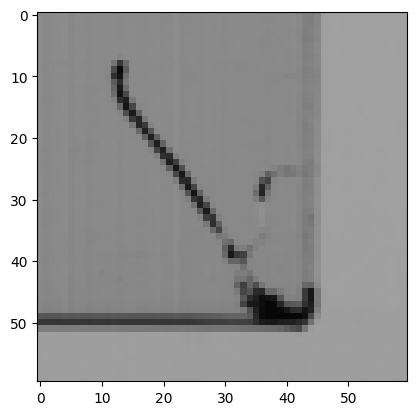

In [12]:
ex = resize_image(cv2.imread(images_dict['break'][0]), 'break', 60)
print(ex.shape)
plt.imshow(ex)

In [13]:
def preprocess_images(dict, index, size):
    for key in dict.keys():
        dict[key] = [img[:index] + '/' + img[index + 1:] for img in dict[key]]
        dict[key] = [aug for img in dict[key] for aug in augment_image(cv2.imread(img))]
        dict[key] = [resize_image(img, key, size) for img in dict[key]]
    
    return dict

In [14]:
def extend_target_classes(images_classes, n):
    target_classes = []
    for cls in images_classes:
        target_classes.extend([cls] * n)
    
    return target_classes

In [15]:
images_dict = preprocess_images(images_dict, 11, 60)
target_classes = extend_target_classes(images_classes, 4)

# for key in images_dict.keys():
#     images_dict[key] = [img[:11] + '/' + img[12:] for img in images_dict[key]]
#     images_dict[key] = [aug for img in images_dict[key] for aug in augment_image(cv2.imread(img))]
#     images_dict[key] = [resize_image(img, key, 60) for img in images_dict[key]]

# for key in masks_dict.keys():
#     masks_dict[key] = [img[:13] + '/' + img[14:] for img in masks_dict[key]]
#     masks_dict[key] = [aug for img in masks_dict[key] for aug in augment_image(cv2.imread(img))]
#     masks_dict[key] = [resize_image(img, key, 60) for img in masks_dict[key]]

# target_classes = []
# for cls in images_classes:
#     target_classes.extend([cls] * 4)

In [16]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    print('K:',K)

    for cls in K:
        datax_cls = np.random.permutation(datax[cls])[:(n_support + n_query)]
        sample.append(datax_cls)

    sample = np.array(sample)
    sample = torch.from_numpy(sample)

    sample = sample.permute(0, 1, 4, 2, 3)

    return({
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query,
        'classes': list(K)
    })

In [17]:
sample_example = extract_sample(6, 4, 4, images_dict, images_classes)
sample_example['images'].shape, sample_example

K: ['dirt' 'break' 'bubble' 'scratch' 'mark' 'point']


(torch.Size([6, 8, 3, 60, 60]),
 {'images': tensor([[[[[141, 140, 143,  ..., 142, 140, 139],
             [145, 141, 141,  ..., 136, 139, 137],
             [145, 142, 145,  ..., 132, 133, 128],
             ...,
             [141, 138, 130,  ..., 143, 140, 142],
             [143, 142, 137,  ..., 141, 142, 140],
             [140, 143, 141,  ..., 145, 142, 142]],
  
            [[141, 140, 143,  ..., 142, 140, 139],
             [145, 141, 141,  ..., 136, 139, 137],
             [145, 142, 145,  ..., 132, 133, 128],
             ...,
             [141, 138, 130,  ..., 143, 140, 142],
             [143, 142, 137,  ..., 141, 142, 140],
             [140, 143, 141,  ..., 145, 142, 142]],
  
            [[141, 140, 143,  ..., 142, 140, 139],
             [145, 141, 141,  ..., 136, 139, 137],
             [145, 142, 145,  ..., 132, 133, 128],
             ...,
             [141, 138, 130,  ..., 143, 140, 142],
             [143, 142, 137,  ..., 141, 142, 140],
             [140, 143, 141, 

In [18]:
def display_sample(sample):
    sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
    plt.figure(figsize = (16,7))
    plt.imshow(out.permute(1, 2, 0))

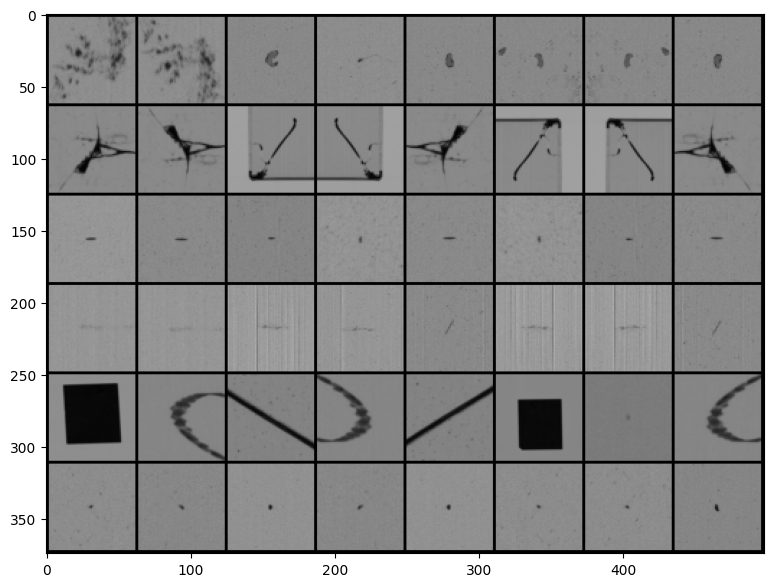

In [19]:
display_sample(sample_example['images'])

In [20]:
def euclidean_dist(x, y):
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

In [21]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        super(ProtoNet, self).__init__()
        self.encoder = encoder#.cuda()

    def set_forward_loss(self, sample, accuracy_dict):
        """
        Computes loss, accuracy and output for classification task
        Args:
            sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
        Returns:
            torch.Tensor: shape(2), loss, accuracy and y_hat
        """
        sample_images = sample['images']#.cuda()
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']
        sample_labels = sample['classes']

        x_support = sample_images[:, :n_support]
        x_query = sample_images[:, n_support:]

        #target indices are 0 ... n_way-1
        target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
        target_inds = Variable(target_inds, requires_grad=False)
        target_inds = target_inds#.cuda()

        #encode images of the support and the query set
        x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                        x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
        
        z = self.encoder.forward(x.float())
        z_dim = z.size(-1) 
        z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
        z_query = z[n_way*n_support:]

        #compute distances
        dists = euclidean_dist(z_query, z_proto)

        #compute probabilities
        log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)

        loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
        _, y_hat = log_p_y.max(2)
        acc_val = torch.eq(y_hat.squeeze(), target_inds.squeeze()).float().mean()

        accuracy_tensor = []
        for row_target, row_predicted in zip(target_inds.squeeze(), y_hat.squeeze()):
            accuracy = (row_target == row_predicted).float().mean()
            accuracy_tensor.append([accuracy])
        accuracy_tensor = torch.tensor(accuracy_tensor)

        for accuracy, cls in zip(accuracy_tensor, sample_labels):
            if cls not in accuracy_dict:
                accuracy_dict[cls] = []
            accuracy_dict[cls].append(accuracy.item())

        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': y_hat.squeeze(),
            'y_true': target_inds.squeeze()
        }, accuracy_dict

In [22]:
class Flatten(nn.Module):
    def __init__(self):
      super(Flatten, self).__init__()

    def forward(self, x):
      return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
    """
    Loads the prototypical network model
    Arg:
        x_dim (tuple): dimension of input image
        hid_dim (int): dimension of hidden layers in conv blocks
        z_dim (int): dimension of embedded image
    Returns:
        Model (Class ProtoNet)
    """
    x_dim = kwargs['x_dim']
    hid_dim = kwargs['hid_dim']
    z_dim = kwargs['z_dim']

    def conv_block(in_channels, out_channels):
      return nn.Sequential(
          nn.Conv2d(in_channels, out_channels, 3, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(),
          nn.MaxPool2d(2)
          )
    
    encoder = nn.Sequential(
      conv_block(x_dim[0], hid_dim),
      conv_block(hid_dim, hid_dim),
      conv_block(hid_dim, hid_dim),
      conv_block(hid_dim, z_dim),
      Flatten()
    )
      
    return ProtoNet(encoder)

In [23]:
def  split_train_test(data, percentage = 3/4):
    train_x = {}
    test_x = {}
    for key in data.keys():
        dim = len(data[key])
        train_x[key] = data[key][:int(len(data[key])*percentage)]
        test_x[key] = data[key][-int(dim - int(dim*percentage)):]

    train_y = []
    test_y = []
    for key in data.keys():
        dim = len(data[key])
        train_y.extend([key] * int(dim*percentage))
        test_y.extend([key] * int(dim - int(dim*percentage)))

    for k in images_dict.keys():
        print(len(images_dict[k]))
    print('-----')
    for k in train_x.keys():
        print(len(train_x[k]))
    print('-----')
    for k in test_x.keys():
        print(len(test_x[k]))
    
    return train_x, train_y, test_x, test_y

In [24]:
train_x, train_y, test_x, test_y = split_train_test(images_dict, 1/2)

8
20
20
20
20
20
-----
4
10
10
10
10
10
-----
4
10
10
10
10
10


# Train

In [25]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, epochs, episodes):
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0 #epochs done so far

    accuracy_dict = {}
    final_accuracy = 0

    while epoch < epochs:
        running_loss = 0.0
        running_acc = 0.0

        for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output, accuracy_dict = model.set_forward_loss(sample, accuracy_dict)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()
            epoch_loss = running_loss / episodes
            epoch_acc = running_acc / episodes
            print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
            final_accuracy = epoch_acc
            epoch += 1
            scheduler.step()

    return accuracy_dict, final_accuracy

In [26]:
def print_dictionary(dictionary):
    for key, values in dictionary.items():
        average = round(sum(values) / len(values), 3)
        print(f"{key}: Average recall: {average}")

In [27]:
%%time

model = load_protonet_conv(
    x_dim=(3,60,60),
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 3
n_support = 2
n_query = 1

epochs = 10
episodes = 50

accuracy_dict, _ = train(model, optimizer, train_x, train_y, n_way, n_support, n_query, epochs, episodes)
print('----------------------------------------------')
print_dictionary(accuracy_dict)

C:\Users\matte\AppData\Local\Temp\ipykernel_4876\1451704302.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['point' 'dirt' 'break']
Epoch 1 -- Loss: 0.0000 Acc: 0.0200
K: ['scratch' 'mark' 'dirt']
Epoch 2 -- Loss: 9.4574 Acc: 0.0333
K: ['scratch' 'break' 'bubble']
Epoch 3 -- Loss: 9.5112 Acc: 0.0467
K: ['break' 'dirt' 'mark']
Epoch 4 -- Loss: 9.7306 Acc: 0.0600
K: ['mark' 'bubble' 'scratch']
Epoch 5 -- Loss: 9.9408 Acc: 0.0733
K: ['scratch' 'dirt' 'bubble']
Epoch 6 -- Loss: 10.3273 Acc: 0.0867
K: ['mark' 'bubble' 'dirt']
Epoch 7 -- Loss: 12.3795 Acc: 0.0933
K: ['dirt' 'bubble' 'mark']
Epoch 8 -- Loss: 12.3795 Acc: 0.1133
K: ['mark' 'break' 'bubble']
Epoch 9 -- Loss: 12.3795 Acc: 0.1333
K: ['mark' 'dirt' 'bubble']
Epoch 10 -- Loss: 12.3795 Acc: 0.1533
K: ['bubble' 'point' 'scratch']
Epoch 11 -- Loss: 12.3795 Acc: 0.1733
K: ['scratch' 'point' 'mark']
Epoch 12 -- Loss: 12.5929 Acc: 0.1867
K: ['break' 'dirt' 'scratch']
Epoch 13 -- Loss: 12.5929 Acc: 0.2067
K: ['dirt' 'bubble' 'scratch']
Epoch 14 -- Loss: 13.1207 Acc: 0.2200
K: ['mark' 'break' 'dirt']
Epoch 15 -- Loss: 13.1480 Acc: 0.2333
K: 

# Test

In [28]:
def test(model, test_x, test_y, n_way, n_support, n_query, episodes):
    running_loss = 0.0
    running_acc = 0.0

    accuracy_dict = {}

    for episode in tnrange(episodes):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output, accuracy_dict = model.set_forward_loss(sample, accuracy_dict)
        running_loss += output['loss']
        running_acc += output['acc']
    avg_loss = running_loss / episodes
    avg_acc = running_acc / episodes
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

    return accuracy_dict, avg_acc

In [29]:
len(train_x), len(train_y), len(test_x), len(test_y)

(6, 54, 6, 54)

In [30]:
n_way = 6
n_support = 2
n_query = 2

episodes = 50

accuracy_dict, _ = test(model, test_x, test_y, n_way, n_support, n_query, episodes)
print('----------------------------------------------')
print_dictionary(accuracy_dict)

C:\Users\matte\AppData\Local\Temp\ipykernel_4876\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['point' 'break' 'bubble' 'dirt' 'scratch' 'mark']
K: ['break' 'bubble' 'scratch' 'dirt' 'point' 'mark']
K: ['break' 'mark' 'scratch' 'dirt' 'bubble' 'point']
K: ['scratch' 'bubble' 'mark' 'point' 'dirt' 'break']
K: ['break' 'mark' 'scratch' 'bubble' 'point' 'dirt']
K: ['mark' 'point' 'scratch' 'bubble' 'break' 'dirt']
K: ['dirt' 'scratch' 'mark' 'bubble' 'point' 'break']
K: ['bubble' 'point' 'break' 'mark' 'scratch' 'dirt']
K: ['point' 'bubble' 'mark' 'dirt' 'scratch' 'break']
K: ['mark' 'point' 'dirt' 'bubble' 'break' 'scratch']
K: ['point' 'dirt' 'scratch' 'break' 'mark' 'bubble']
K: ['bubble' 'scratch' 'break' 'mark' 'dirt' 'point']
K: ['dirt' 'bubble' 'scratch' 'break' 'point' 'mark']
K: ['mark' 'scratch' 'point' 'bubble' 'break' 'dirt']
K: ['break' 'point' 'scratch' 'bubble' 'dirt' 'mark']
K: ['dirt' 'break' 'bubble' 'scratch' 'mark' 'point']
K: ['bubble' 'mark' 'dirt' 'break' 'point' 'scratch']
K: ['mark' 'bubble' 'dirt' 'scratch' 'break' 'point']
K: ['mark' 'scratch' 'bubble

# test on specific sample

In [31]:
accuracy_dict = {}

K: ['mark' 'break' 'point']
mark: Average recall: 1.0
break: Average recall: 1.0
point: Average recall: 1.0


{'loss': 0.15703722834587097,
 'acc': 1.0,
 'y_hat': tensor([0, 1, 2]),
 'y_true': tensor([0, 1, 2])}

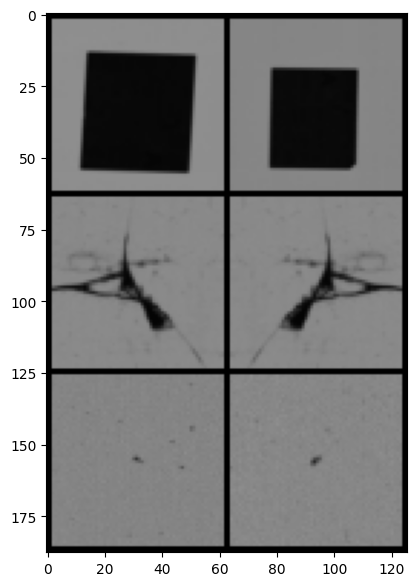

In [32]:
my_sample = extract_sample(3, 1, 1, test_x, test_y)
display_sample(my_sample['images'])
model = load_protonet_conv(
    x_dim=(3,60,60),
    hid_dim=64,
    z_dim=64,
)
my_loss, my_output, accuracy_dict = model.set_forward_loss(my_sample, accuracy_dict)
print_dictionary(accuracy_dict)
my_output

In [33]:
def train_test_pipeline(images_dict, split_percentage = 3/4, 
                        train_n_way = 3, train_n_support = 2, train_n_query = 1, train_epochs = 10, train_episodes = 50, 
                        test_n_way = 3, test_n_support = 1, test_n_query = 1, test_episodes = 50):
    
    train_x, train_y, test_x, test_y = split_train_test(images_dict, split_percentage)

    model = load_protonet_conv(
        x_dim=(3,60,60),
        hid_dim=64,
        z_dim=64,
    )

    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    train_accuracy_dict, train_accuracy = train(model, optimizer, train_x, train_y, train_n_way, train_n_support, train_n_query, train_epochs, train_episodes)

    test_accuracy_dict, test_accuracy = test(model, test_x, test_y, test_n_way, test_n_support, test_n_query, test_episodes)

    print('----------------------------------------------')
    print('Train results')
    print_dictionary(train_accuracy_dict)
    print('----------------------------------------------')
    print('Test results')
    print_dictionary(test_accuracy_dict)

    return train_accuracy_dict, train_accuracy, test_accuracy_dict, test_accuracy

# Training and testing on different number of episodes

In [47]:
def plot_accuracies_dict(accuracies_dict, title):
    for dictionary in accuracies_dict:
        keys = list(dictionary.keys())
        values = list(dictionary.values())
        x = range(len(keys))
        
        plt.figure(figsize=(6, 4))
        plt.bar(x, values)
        plt.xticks(x, keys)
        plt.xlabel('labels')
        plt.ylabel('accuracy')
        plt.title(title)
        plt.show()

In [35]:
def plot_accuracies(increased_episodes, train_accuracies, test_accuracies):
    plt.plot(increased_episodes, train_accuracies, label='train_accuracies')
    plt.plot(increased_episodes, test_accuracies, label='test_accuracies')
    plt.xlabel('# of episodes')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title('evolution of accuracy with # of episodes')
    plt.show()

In [36]:
images, images_classes, images_dict = extract_images('../data/img/')
images_dict = preprocess_images(images_dict, 11, 60)

In [37]:
increased_episodes = [100, 250, 500]
train_accuracies_dict, test_accuracies_dict = [], []
train_accuracies, test_accuracies = [], []

for episodes in increased_episodes:
    train_accuracy_dict, train_accuracy, test_accuracy_dict, test_accuracy = train_test_pipeline(images_dict, train_episodes = episodes, test_episodes = episodes)
    train_accuracies_dict.append(train_accuracy_dict)
    test_accuracies_dict.append(test_accuracy_dict)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

8
20
20
20
20
20
-----
6
15
15
15
15
15
-----
2
5
5
5
5
5


C:\Users\matte\AppData\Local\Temp\ipykernel_4876\1451704302.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

K: ['point' 'bubble' 'scratch']
Epoch 1 -- Loss: 0.0000 Acc: 0.0100
K: ['scratch' 'point' 'bubble']
Epoch 2 -- Loss: 0.0000 Acc: 0.0200
K: ['scratch' 'point' 'dirt']
Epoch 3 -- Loss: 0.0000 Acc: 0.0300
K: ['mark' 'point' 'bubble']
Epoch 4 -- Loss: 1.7159 Acc: 0.0367
K: ['break' 'dirt' 'mark']
Epoch 5 -- Loss: 1.7159 Acc: 0.0467
K: ['point' 'scratch' 'break']
Epoch 6 -- Loss: 1.8094 Acc: 0.0533
K: ['point' 'bubble' 'scratch']
Epoch 7 -- Loss: 2.0025 Acc: 0.0600
K: ['break' 'bubble' 'point']
Epoch 8 -- Loss: 2.2432 Acc: 0.0667
K: ['dirt' 'scratch' 'break']
Epoch 9 -- Loss: 2.2432 Acc: 0.0767
K: ['dirt' 'point' 'scratch']
Epoch 10 -- Loss: 2.2953 Acc: 0.0833
K: ['break' 'dirt' 'scratch']
Epoch 11 -- Loss: 2.2953 Acc: 0.0933
K: ['point' 'break' 'mark']
Epoch 12 -- Loss: 2.2953 Acc: 0.1033
K: ['dirt' 'break' 'mark']
Epoch 13 -- Loss: 3.7910 Acc: 0.1067
K: ['break' 'point' 'bubble']
Epoch 14 -- Loss: 3.7910 Acc: 0.1167
K: ['bubble' 'dirt' 'point']
Epoch 15 -- Loss: 4.1485 Acc: 0.1233
K: ['sc

C:\Users\matte\AppData\Local\Temp\ipykernel_4876\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/100 [00:00<?, ?it/s]

K: ['scratch' 'point' 'break']
K: ['point' 'break' 'dirt']
K: ['bubble' 'mark' 'scratch']
K: ['bubble' 'scratch' 'break']
K: ['break' 'point' 'scratch']
K: ['bubble' 'mark' 'dirt']
K: ['point' 'mark' 'break']
K: ['break' 'dirt' 'scratch']
K: ['mark' 'break' 'point']
K: ['point' 'dirt' 'mark']
K: ['dirt' 'scratch' 'mark']
K: ['bubble' 'dirt' 'mark']
K: ['mark' 'break' 'bubble']
K: ['break' 'bubble' 'dirt']
K: ['break' 'bubble' 'mark']
K: ['break' 'scratch' 'dirt']
K: ['bubble' 'scratch' 'mark']
K: ['dirt' 'scratch' 'bubble']
K: ['mark' 'point' 'scratch']
K: ['scratch' 'dirt' 'bubble']
K: ['point' 'break' 'mark']
K: ['break' 'mark' 'bubble']
K: ['scratch' 'mark' 'break']
K: ['dirt' 'scratch' 'bubble']
K: ['dirt' 'scratch' 'point']
K: ['scratch' 'mark' 'bubble']
K: ['break' 'dirt' 'mark']
K: ['dirt' 'point' 'bubble']
K: ['point' 'break' 'scratch']
K: ['break' 'bubble' 'point']
K: ['bubble' 'scratch' 'mark']
K: ['point' 'scratch' 'break']
K: ['break' 'scratch' 'point']
K: ['break' 'scratch

Epoch 1 train:   0%|          | 0/250 [00:00<?, ?it/s]

K: ['dirt' 'break' 'scratch']
Epoch 1 -- Loss: 0.0000 Acc: 0.0040
K: ['dirt' 'scratch' 'bubble']
Epoch 2 -- Loss: 0.0028 Acc: 0.0067
K: ['mark' 'break' 'point']
Epoch 3 -- Loss: 0.1488 Acc: 0.0093
K: ['bubble' 'mark' 'point']
Epoch 4 -- Loss: 0.2903 Acc: 0.0120
K: ['point' 'break' 'dirt']
Epoch 5 -- Loss: 0.3373 Acc: 0.0133
K: ['mark' 'scratch' 'point']
Epoch 6 -- Loss: 0.3373 Acc: 0.0173
K: ['scratch' 'break' 'dirt']
Epoch 7 -- Loss: 0.3373 Acc: 0.0213
K: ['scratch' 'point' 'bubble']
Epoch 8 -- Loss: 0.3373 Acc: 0.0253
K: ['point' 'scratch' 'break']
Epoch 9 -- Loss: 0.3373 Acc: 0.0293
K: ['dirt' 'mark' 'point']
Epoch 10 -- Loss: 0.3533 Acc: 0.0307
K: ['dirt' 'point' 'scratch']
Epoch 11 -- Loss: 0.3826 Acc: 0.0333
K: ['point' 'mark' 'break']
Epoch 12 -- Loss: 0.4422 Acc: 0.0360
K: ['point' 'bubble' 'dirt']
Epoch 13 -- Loss: 0.4422 Acc: 0.0400
K: ['dirt' 'break' 'point']
Epoch 14 -- Loss: 0.4492 Acc: 0.0427
K: ['bubble' 'dirt' 'break']
Epoch 15 -- Loss: 0.6859 Acc: 0.0453
K: ['dirt' 'bu

  0%|          | 0/250 [00:00<?, ?it/s]

K: ['scratch' 'break' 'point']
K: ['point' 'bubble' 'break']
K: ['break' 'dirt' 'scratch']
K: ['scratch' 'point' 'dirt']
K: ['scratch' 'break' 'dirt']
K: ['break' 'dirt' 'bubble']
K: ['point' 'break' 'mark']
K: ['break' 'bubble' 'scratch']
K: ['break' 'scratch' 'dirt']
K: ['bubble' 'point' 'break']
K: ['dirt' 'bubble' 'break']
K: ['mark' 'bubble' 'point']
K: ['point' 'break' 'dirt']
K: ['break' 'dirt' 'mark']
K: ['dirt' 'point' 'mark']
K: ['break' 'mark' 'point']
K: ['point' 'scratch' 'dirt']
K: ['break' 'dirt' 'bubble']
K: ['point' 'scratch' 'bubble']
K: ['scratch' 'break' 'point']
K: ['dirt' 'mark' 'break']
K: ['break' 'dirt' 'bubble']
K: ['dirt' 'break' 'point']
K: ['dirt' 'bubble' 'break']
K: ['point' 'scratch' 'dirt']
K: ['scratch' 'bubble' 'mark']
K: ['dirt' 'point' 'mark']
K: ['scratch' 'break' 'bubble']
K: ['scratch' 'break' 'mark']
K: ['dirt' 'mark' 'scratch']
K: ['point' 'dirt' 'break']
K: ['break' 'scratch' 'bubble']
K: ['break' 'scratch' 'bubble']
K: ['mark' 'bubble' 'scrat

Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

K: ['break' 'dirt' 'scratch']
Epoch 1 -- Loss: 0.0000 Acc: 0.0020
K: ['scratch' 'dirt' 'break']
Epoch 2 -- Loss: 0.0000 Acc: 0.0040
K: ['mark' 'scratch' 'bubble']
Epoch 3 -- Loss: 0.0000 Acc: 0.0060
K: ['break' 'point' 'mark']
Epoch 4 -- Loss: 0.1049 Acc: 0.0073
K: ['mark' 'point' 'break']
Epoch 5 -- Loss: 0.1695 Acc: 0.0087
K: ['point' 'break' 'mark']
Epoch 6 -- Loss: 0.1981 Acc: 0.0100
K: ['dirt' 'mark' 'bubble']
Epoch 7 -- Loss: 0.6408 Acc: 0.0113
K: ['scratch' 'break' 'dirt']
Epoch 8 -- Loss: 0.6408 Acc: 0.0133
K: ['mark' 'dirt' 'point']
Epoch 9 -- Loss: 0.6408 Acc: 0.0153
K: ['dirt' 'break' 'mark']
Epoch 10 -- Loss: 0.6408 Acc: 0.0173
K: ['break' 'scratch' 'bubble']
Epoch 11 -- Loss: 0.6408 Acc: 0.0193
K: ['mark' 'bubble' 'dirt']
Epoch 12 -- Loss: 0.8546 Acc: 0.0200
K: ['bubble' 'dirt' 'point']
Epoch 13 -- Loss: 0.8806 Acc: 0.0207
K: ['dirt' 'break' 'bubble']
Epoch 14 -- Loss: 0.8806 Acc: 0.0227
K: ['mark' 'point' 'scratch']
Epoch 15 -- Loss: 0.8806 Acc: 0.0247
K: ['break' 'mark' 

  0%|          | 0/500 [00:00<?, ?it/s]

K: ['mark' 'bubble' 'break']
K: ['dirt' 'break' 'mark']
K: ['bubble' 'point' 'mark']
K: ['break' 'point' 'scratch']
K: ['bubble' 'scratch' 'mark']
K: ['mark' 'break' 'point']
K: ['bubble' 'break' 'point']
K: ['bubble' 'dirt' 'point']
K: ['scratch' 'mark' 'point']
K: ['mark' 'scratch' 'dirt']
K: ['scratch' 'break' 'bubble']
K: ['bubble' 'mark' 'dirt']
K: ['scratch' 'dirt' 'bubble']
K: ['point' 'dirt' 'bubble']
K: ['break' 'dirt' 'scratch']
K: ['break' 'dirt' 'mark']
K: ['break' 'point' 'dirt']
K: ['bubble' 'dirt' 'scratch']
K: ['bubble' 'scratch' 'dirt']
K: ['dirt' 'scratch' 'break']
K: ['scratch' 'bubble' 'break']
K: ['break' 'point' 'mark']
K: ['dirt' 'mark' 'point']
K: ['dirt' 'break' 'mark']
K: ['break' 'bubble' 'dirt']
K: ['dirt' 'point' 'scratch']
K: ['mark' 'dirt' 'bubble']
K: ['break' 'mark' 'scratch']
K: ['point' 'dirt' 'mark']
K: ['point' 'bubble' 'mark']
K: ['break' 'point' 'bubble']
K: ['dirt' 'bubble' 'scratch']
K: ['bubble' 'scratch' 'mark']
K: ['dirt' 'point' 'bubble']
K:

In [43]:
plot_accuracies_dict(train_accuracies_dict, 'Train accuracies')

TypeError: unsupported operand type(s) for +: 'int' and 'list'

<Figure size 600x400 with 0 Axes>

In [ ]:
plot_accuracies_dict(test_accuracies_dict, 'Test accuracies')

In [ ]:
plot_accuracies(increased_episodes, train_accuracies, test_accuracies)

# Using default dataset + background (opt_bckg)

In [ ]:
images, images_classes, images_dict = extract_images('../data/views_opt_bckg/img/')

In [ ]:
classes = set(images_classes)
len(images), len(images_classes), len(classes)

(31, 31, 7)

In [ ]:
classes

{'background', 'break', 'bubble', 'dirt', 'mark', 'point', 'scratch'}

In [ ]:
images_dict = preprocess_images(images_dict, 26, 60)
target_classes = extend_target_classes(images_classes, 4)

In [ ]:
train_test_pipeline(images_dict)

20
8
20
20
16
20
20
-----
15
6
15
15
12
15
15
-----
5
2
5
5
4
5
5


C:\Users\matte\AppData\Local\Temp\ipykernel_12724\637486396.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['mark' 'scratch' 'break']
Epoch 1 -- Loss: 0.0000 Acc: 0.0200
K: ['scratch' 'dirt' 'point']
Epoch 2 -- Loss: 0.0000 Acc: 0.0400
K: ['background' 'dirt' 'point']
Epoch 3 -- Loss: 0.0000 Acc: 0.0600
K: ['scratch' 'break' 'background']
Epoch 4 -- Loss: 7.6687 Acc: 0.0733
K: ['background' 'scratch' 'bubble']
Epoch 5 -- Loss: 7.9096 Acc: 0.0867
K: ['point' 'dirt' 'mark']
Epoch 6 -- Loss: 8.5359 Acc: 0.1000
K: ['bubble' 'scratch' 'mark']
Epoch 7 -- Loss: 9.8068 Acc: 0.1133
K: ['mark' 'scratch' 'point']
Epoch 8 -- Loss: 9.8068 Acc: 0.1333
K: ['mark' 'bubble' 'scratch']
Epoch 9 -- Loss: 10.2176 Acc: 0.1467
K: ['dirt' 'bubble' 'break']
Epoch 10 -- Loss: 10.5826 Acc: 0.1600
K: ['mark' 'dirt' 'point']
Epoch 11 -- Loss: 11.4324 Acc: 0.1733
K: ['scratch' 'mark' 'bubble']
Epoch 12 -- Loss: 11.4324 Acc: 0.1933
K: ['bubble' 'dirt' 'break']
Epoch 13 -- Loss: 11.4324 Acc: 0.2133
K: ['background' 'scratch' 'point']
Epoch 14 -- Loss: 14.6511 Acc: 0.2267
K: ['scratch' 'break' 'background']
Epoch 15 -- 

C:\Users\matte\AppData\Local\Temp\ipykernel_12724\2734032620.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['background' 'point' 'bubble']
K: ['break' 'point' 'bubble']
K: ['break' 'background' 'point']
K: ['dirt' 'background' 'point']
K: ['break' 'dirt' 'bubble']
K: ['break' 'mark' 'bubble']
K: ['dirt' 'break' 'mark']
K: ['dirt' 'bubble' 'background']
K: ['dirt' 'scratch' 'background']
K: ['break' 'background' 'dirt']
K: ['dirt' 'scratch' 'point']
K: ['bubble' 'break' 'background']
K: ['dirt' 'mark' 'scratch']
K: ['break' 'background' 'dirt']
K: ['bubble' 'mark' 'scratch']
K: ['point' 'mark' 'bubble']
K: ['mark' 'bubble' 'scratch']
K: ['scratch' 'dirt' 'point']
K: ['background' 'scratch' 'point']
K: ['point' 'dirt' 'mark']
K: ['dirt' 'point' 'break']
K: ['bubble' 'mark' 'dirt']
K: ['break' 'background' 'point']
K: ['point' 'background' 'scratch']
K: ['background' 'mark' 'break']
K: ['mark' 'break' 'dirt']
K: ['background' 'mark' 'bubble']
K: ['point' 'bubble' 'break']
K: ['background' 'dirt' 'point']
K: ['break' 'mark' 'scratch']
K: ['scratch' 'mark' 'break']
K: ['mark' 'bubble' 'break'

# Training and testing on different number of episodes

In [ ]:
increased_episodes = [100, 250, 500]
train_accuracies_dict, test_accuracies_dict = [], []
train_accuracies, test_accuracies = [], []

for episodes in increased_episodes:
    train_accuracy_dict, train_accuracy, test_accuracy_dict, test_accuracy = train_test_pipeline(images_dict, train_episodes = episodes, test_episodes = episodes)
    train_accuracies_dict.append(train_accuracy_dict)
    test_accuracies_dict.append(test_accuracy_dict)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

In [ ]:
plot_accuracies_dict(train_accuracies_dict, 'Train accuracies')

In [ ]:
plot_accuracies_dict(test_accuracies_dict, 'Test accuracies')

In [ ]:
plot_accuracies(increased_episodes, train_accuracies, test_accuracies)

# Using qplus dataset (general classes)

In [ ]:
images, images_classes, images_dict = extract_images('../data/views_qplus/img/')

In [ ]:
classes = set(images_classes)
len(images), len(images_classes), len(classes)

(52, 52, 11)

In [ ]:
classes

{'altro',
 'break',
 'bubble',
 'coating',
 'dirt',
 'dust',
 'glass',
 'halo',
 'mark',
 'point',
 'scratch'}

In [ ]:
images_dict = preprocess_images(images_dict, 23, 60)
target_classes = extend_target_classes(images_classes, 4)

In [ ]:
train_test_pipeline(images_dict)

20
8
20
20
20
20
20
20
20
20
20
-----
15
6
15
15
15
15
15
15
15
15
15
-----
5
2
5
5
5
5
5
5
5
5
5


C:\Users\matte\AppData\Local\Temp\ipykernel_12724\637486396.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['glass' 'altro' 'coating']
Epoch 1 -- Loss: 0.0000 Acc: 0.0200
K: ['glass' 'altro' 'break']
Epoch 2 -- Loss: 0.0000 Acc: 0.0400
K: ['altro' 'coating' 'bubble']
Epoch 3 -- Loss: 0.0000 Acc: 0.0600
K: ['scratch' 'dirt' 'point']
Epoch 4 -- Loss: 4.4590 Acc: 0.0733
K: ['mark' 'point' 'glass']
Epoch 5 -- Loss: 5.4362 Acc: 0.0800
K: ['break' 'bubble' 'coating']
Epoch 6 -- Loss: 5.4362 Acc: 0.1000
K: ['break' 'scratch' 'bubble']
Epoch 7 -- Loss: 6.8830 Acc: 0.1133
K: ['dust' 'glass' 'mark']
Epoch 8 -- Loss: 6.9143 Acc: 0.1267
K: ['break' 'glass' 'altro']
Epoch 9 -- Loss: 6.9143 Acc: 0.1467
K: ['glass' 'halo' 'break']
Epoch 10 -- Loss: 7.9722 Acc: 0.1600
K: ['mark' 'halo' 'point']
Epoch 11 -- Loss: 7.9722 Acc: 0.1800
K: ['dust' 'break' 'point']
Epoch 12 -- Loss: 7.9722 Acc: 0.2000
K: ['dirt' 'mark' 'point']
Epoch 13 -- Loss: 8.0033 Acc: 0.2133
K: ['bubble' 'mark' 'dust']
Epoch 14 -- Loss: 8.0066 Acc: 0.2333
K: ['glass' 'halo' 'point']
Epoch 15 -- Loss: 8.0066 Acc: 0.2533
K: ['dust' 'scratc

C:\Users\matte\AppData\Local\Temp\ipykernel_12724\2734032620.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['halo' 'dust' 'point']
K: ['halo' 'bubble' 'dirt']
K: ['halo' 'glass' 'mark']
K: ['break' 'altro' 'point']
K: ['coating' 'bubble' 'point']
K: ['mark' 'scratch' 'glass']
K: ['mark' 'altro' 'bubble']
K: ['halo' 'mark' 'break']
K: ['dust' 'break' 'mark']
K: ['dust' 'break' 'glass']
K: ['point' 'halo' 'dust']
K: ['point' 'halo' 'mark']
K: ['mark' 'dust' 'break']
K: ['scratch' 'halo' 'point']
K: ['coating' 'mark' 'bubble']
K: ['dirt' 'glass' 'bubble']
K: ['coating' 'halo' 'mark']
K: ['point' 'coating' 'dust']
K: ['dust' 'scratch' 'bubble']
K: ['coating' 'altro' 'scratch']
K: ['bubble' 'altro' 'scratch']
K: ['halo' 'glass' 'bubble']
K: ['scratch' 'coating' 'point']
K: ['point' 'dust' 'halo']
K: ['point' 'dust' 'mark']
K: ['coating' 'dust' 'mark']
K: ['point' 'halo' 'mark']
K: ['point' 'break' 'bubble']
K: ['coating' 'dust' 'halo']
K: ['bubble' 'dust' 'point']
K: ['glass' 'dirt' 'point']
K: ['coating' 'bubble' 'break']
K: ['altro' 'break' 'mark']
K: ['coating' 'dust' 'halo']
K: ['bubble' 

# Training and testing on different number of episodes

In [ ]:
increased_episodes = [100, 250, 500]
train_accuracies_dict, test_accuracies_dict = [], []
train_accuracies, test_accuracies = [], []

for episodes in increased_episodes:
    train_accuracy_dict, train_accuracy, test_accuracy_dict, test_accuracy = train_test_pipeline(images_dict, train_episodes = episodes, test_episodes = episodes)
    train_accuracies_dict.append(train_accuracy_dict)
    test_accuracies_dict.append(test_accuracy_dict)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

In [ ]:
plot_accuracies_dict(train_accuracies_dict, 'Train accuracies')

In [ ]:
plot_accuracies_dict(test_accuracies_dict, 'Test accuracies')

In [ ]:
plot_accuracies(increased_episodes, train_accuracies, test_accuracies)

# Using qplus dataset (detailed classes)

In [ ]:
images, images_classes, images_dict = extract_images('../data/views_qplus/img/', '_did_')

In [ ]:
classes = set(images_classes)
len(images), len(images_classes), len(classes)

(72, 72, 15)

In [ ]:
classes

{'altro',
 'break',
 'bubble',
 'bubble_hole',
 'coating',
 'dirt',
 'dirt_halo',
 'dust',
 'glass_id',
 'halo',
 'mark',
 'point',
 'scratch_heavy',
 'scratch_light',
 'scratch_multi'}

In [ ]:
images_dict = preprocess_images(images_dict, 23, 60)
target_classes = extend_target_classes(images_classes, 4)

In [ ]:
train_test_pipeline(images_dict)

20
8
20
20
20
20
20
20
20
20
20
20
20
20
20
-----
15
6
15
15
15
15
15
15
15
15
15
15
15
15
15
-----
5
2
5
5
5
5
5
5
5
5
5
5
5
5
5


C:\Users\matte\AppData\Local\Temp\ipykernel_12724\637486396.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['coating' 'mark' 'bubble_hole']
Epoch 1 -- Loss: 0.7999 Acc: 0.0133
K: ['halo' 'altro' 'dust']
Epoch 2 -- Loss: 1.3201 Acc: 0.0267
K: ['dirt_halo' 'bubble_hole' 'scratch_multi']
Epoch 3 -- Loss: 1.3201 Acc: 0.0467
K: ['halo' 'scratch_heavy' 'mark']
Epoch 4 -- Loss: 1.3431 Acc: 0.0600
K: ['dirt' 'halo' 'mark']
Epoch 5 -- Loss: 3.2800 Acc: 0.0667
K: ['glass_id' 'point' 'altro']
Epoch 6 -- Loss: 3.2800 Acc: 0.0867
K: ['point' 'break' 'dust']
Epoch 7 -- Loss: 4.6293 Acc: 0.1000
K: ['bubble_hole' 'break' 'glass_id']
Epoch 8 -- Loss: 4.6293 Acc: 0.1200
K: ['scratch_heavy' 'bubble_hole' 'altro']
Epoch 9 -- Loss: 6.2772 Acc: 0.1333
K: ['dust' 'point' 'dirt_halo']
Epoch 10 -- Loss: 6.5758 Acc: 0.1467
K: ['point' 'dirt' 'glass_id']
Epoch 11 -- Loss: 6.5758 Acc: 0.1667
K: ['scratch_heavy' 'glass_id' 'bubble_hole']
Epoch 12 -- Loss: 6.8587 Acc: 0.1800
K: ['scratch_multi' 'point' 'dust']
Epoch 13 -- Loss: 6.8587 Acc: 0.2000
K: ['bubble_hole' 'break' 'glass_id']
Epoch 14 -- Loss: 6.8965 Acc: 0.2

C:\Users\matte\AppData\Local\Temp\ipykernel_12724\2734032620.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['point' 'scratch_multi' 'halo']
K: ['halo' 'point' 'dust']
K: ['scratch_multi' 'dirt' 'glass_id']
K: ['dust' 'mark' 'bubble_hole']
K: ['point' 'altro' 'coating']
K: ['scratch_heavy' 'scratch_light' 'coating']
K: ['scratch_light' 'dust' 'bubble_hole']
K: ['scratch_light' 'dirt_halo' 'dust']
K: ['bubble' 'halo' 'scratch_heavy']
K: ['dirt_halo' 'bubble' 'scratch_multi']
K: ['scratch_heavy' 'halo' 'point']
K: ['bubble_hole' 'dirt' 'point']
K: ['point' 'dirt_halo' 'scratch_light']
K: ['bubble' 'altro' 'break']
K: ['mark' 'coating' 'break']
K: ['halo' 'dirt' 'break']
K: ['mark' 'point' 'scratch_multi']
K: ['point' 'dust' 'bubble_hole']
K: ['scratch_multi' 'halo' 'break']
K: ['scratch_multi' 'bubble_hole' 'point']
K: ['break' 'scratch_multi' 'halo']
K: ['break' 'scratch_light' 'halo']
K: ['scratch_multi' 'dirt_halo' 'glass_id']
K: ['scratch_multi' 'coating' 'altro']
K: ['altro' 'halo' 'dirt']
K: ['bubble' 'altro' 'mark']
K: ['bubble_hole' 'coating' 'scratch_multi']
K: ['altro' 'scratch_mu

# Training and testing on different number of episodes

In [ ]:
increased_episodes = [100, 250, 500]
train_accuracies_dict, test_accuracies_dict = [], []
train_accuracies, test_accuracies = [], []

for episodes in increased_episodes:
    train_accuracy_dict, train_accuracy, test_accuracy_dict, test_accuracy = train_test_pipeline(images_dict, train_episodes = episodes, test_episodes = episodes)
    train_accuracies_dict.append(train_accuracy_dict)
    test_accuracies_dict.append(test_accuracy_dict)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

In [ ]:
plot_accuracies_dict(train_accuracies_dict, 'Train accuracies')

In [ ]:
plot_accuracies_dict(test_accuracies_dict, 'Test accuracies')

In [ ]:
plot_accuracies(increased_episodes, train_accuracies, test_accuracies)

# Using qplus dataset to predict opt_bckg

In [ ]:
train_images, train_images_classes, train_images_dict = extract_images('../data/views_qplus/img/', '_did_')

In [ ]:
train_classes = set(train_images_classes)
len(train_images), len(train_images_classes), len(train_classes)

(72, 72, 15)

In [ ]:
train_classes

{'altro',
 'break',
 'bubble',
 'bubble_hole',
 'coating',
 'dirt',
 'dirt_halo',
 'dust',
 'glass_id',
 'halo',
 'mark',
 'point',
 'scratch_heavy',
 'scratch_light',
 'scratch_multi'}

In [ ]:
train_images_dict = preprocess_images(train_images_dict, 23, 60)
train_target_classes = extend_target_classes(train_images_classes, 4)

In [ ]:
test_images, test_images_classes, test_images_dict = extract_images('../data/views_opt_bckg/img/')

In [ ]:
test_classes = set(test_images_classes)
len(test_images), len(test_images_classes), len(test_classes)

(31, 31, 7)

In [ ]:
test_classes

{'background', 'break', 'bubble', 'dirt', 'mark', 'point', 'scratch'}

In [ ]:
test_images_dict = preprocess_images(test_images_dict, 26, 60)
test_target_classes = extend_target_classes(test_images_classes, 4)

In [ ]:
model = load_protonet_conv(
    x_dim=(3,60,60),
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

train_accuracy_dict = train(model, optimizer, train_images_dict, train_target_classes, 3, 2, 1, 50, 50)

test_accuracy_dict = test(model, test_images_dict, test_target_classes, 3, 1, 1, 50)

print('----------------------------------------------')
print('Train results')
print_dictionary(train_accuracy_dict)
print('----------------------------------------------')
print('Test results')
print_dictionary(test_accuracy_dict)

C:\Users\matte\AppData\Local\Temp\ipykernel_12724\637486396.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['bubble_hole' 'dirt_halo' 'break']
Epoch 1 -- Loss: 0.0000 Acc: 0.0200
K: ['mark' 'scratch_light' 'dirt']
Epoch 2 -- Loss: 4.8801 Acc: 0.0333
K: ['glass_id' 'altro' 'dirt_halo']
Epoch 3 -- Loss: 4.8806 Acc: 0.0533
K: ['mark' 'halo' 'scratch_multi']
Epoch 4 -- Loss: 4.8806 Acc: 0.0733
K: ['point' 'dirt' 'halo']
Epoch 5 -- Loss: 4.8806 Acc: 0.0933
K: ['halo' 'scratch_heavy' 'glass_id']
Epoch 6 -- Loss: 4.8806 Acc: 0.1133
K: ['scratch_light' 'break' 'bubble']
Epoch 7 -- Loss: 4.8806 Acc: 0.1333
K: ['dirt' 'break' 'bubble']
Epoch 8 -- Loss: 4.8806 Acc: 0.1533
K: ['mark' 'break' 'halo']
Epoch 9 -- Loss: 7.4697 Acc: 0.1600
K: ['scratch_multi' 'dirt_halo' 'bubble_hole']
Epoch 10 -- Loss: 7.4701 Acc: 0.1800
K: ['dust' 'dirt_halo' 'scratch_multi']
Epoch 11 -- Loss: 7.4701 Acc: 0.2000
K: ['scratch_heavy' 'scratch_multi' 'mark']
Epoch 12 -- Loss: 7.6520 Acc: 0.2067
K: ['scratch_multi' 'dirt_halo' 'mark']
Epoch 13 -- Loss: 9.8361 Acc: 0.2133
K: ['bubble_hole' 'mark' 'scratch_multi']
Epoch 14 -

C:\Users\matte\AppData\Local\Temp\ipykernel_12724\2734032620.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['mark' 'background' 'point']
K: ['bubble' 'point' 'mark']
K: ['mark' 'background' 'point']
K: ['background' 'bubble' 'dirt']
K: ['dirt' 'scratch' 'break']
K: ['dirt' 'scratch' 'point']
K: ['scratch' 'point' 'bubble']
K: ['bubble' 'dirt' 'mark']
K: ['point' 'bubble' 'background']
K: ['dirt' 'scratch' 'background']
K: ['dirt' 'bubble' 'break']
K: ['bubble' 'break' 'background']
K: ['bubble' 'dirt' 'mark']
K: ['dirt' 'mark' 'scratch']
K: ['break' 'scratch' 'dirt']
K: ['dirt' 'break' 'background']
K: ['break' 'bubble' 'point']
K: ['point' 'scratch' 'background']
K: ['bubble' 'background' 'scratch']
K: ['point' 'mark' 'bubble']
K: ['dirt' 'scratch' 'break']
K: ['scratch' 'background' 'bubble']
K: ['mark' 'dirt' 'scratch']
K: ['dirt' 'bubble' 'scratch']
K: ['background' 'scratch' 'bubble']
K: ['point' 'bubble' 'scratch']
K: ['scratch' 'point' 'background']
K: ['scratch' 'dirt' 'mark']
K: ['background' 'mark' 'break']
K: ['break' 'scratch' 'background']
K: ['dirt' 'bubble' 'scratch']
K: [

# Training and testing on different number of episodes

In [ ]:
increased_episodes = [100, 250, 500]
train_accuracies_dict, test_accuracies_dict = [], []
train_accuracies, test_accuracies = [], []

for episodes in increased_episodes:
    train_accuracy_dict, train_accuracy = train(model, optimizer, train_images_dict, train_target_classes, 3, 2, 1, 50, episodes)
    test_accuracy_dict, test_accuracy = test(model, test_images_dict, test_target_classes, 3, 1, 1, episodes)
    train_accuracies_dict.append(train_accuracy_dict)
    test_accuracies_dict.append(test_accuracy_dict)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

In [ ]:
plot_accuracies_dict(train_accuracies_dict, 'Train accuracies')

In [ ]:
plot_accuracies_dict(test_accuracies_dict, 'Test accuracies')

In [ ]:
plot_accuracies(increased_episodes, train_accuracies, test_accuracies)

In [ ]:
# train_accuracy_dict = train(model, optimizer, train_images_dict, train_target_classes, 3, 2, 1, 50, 100)

# test_accuracy_dict = test(model, test_images_dict, test_target_classes, 3, 1, 1, 100)

# print('----------------------------------------------')
# print('Train results')
# print_dictionary(train_accuracy_dict)
# print('----------------------------------------------')
# print('Test results')
# print_dictionary(test_accuracy_dict)

In [ ]:
# train_accuracy_dict = train(model, optimizer, train_images_dict, train_target_classes, 3, 2, 1, 50, 250)

# test_accuracy_dict = test(model, test_images_dict, test_target_classes, 3, 1, 1, 250)

# print('----------------------------------------------')
# print('Train results')
# print_dictionary(train_accuracy_dict)
# print('----------------------------------------------')
# print('Test results')
# print_dictionary(test_accuracy_dict)

In [ ]:
# train_accuracy_dict = train(model, optimizer, train_images_dict, train_target_classes, 3, 2, 1, 50, 500)

# test_accuracy_dict = test(model, test_images_dict, test_target_classes, 3, 1, 1, 500)

# print('----------------------------------------------')
# print('Train results')
# print_dictionary(train_accuracy_dict)
# print('----------------------------------------------')
# print('Test results')
# print_dictionary(test_accuracy_dict)

In [ ]:
print('Finito!')